<a href="https://colab.research.google.com/github/anilaq/capstone/blob/master/Copy_of_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install surprise

     |████████████████████████████████| 6.5MB 5.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1673646 sha256=7308af4c6290e4efcd855810abaa4db57468fba8ea459e6d75d7e103d6edbddd
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import pandas as pd 

import numpy as np 

import random
from random import randint

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds 

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline

from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD

from surprise.similarities import cosine, msd, pearson

from surprise import accuracy 
from surprise import Reader
from surprise import Dataset
from surprise import dataset



# Preprocessing

In [7]:
anime_df = pd.read_csv('./anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
anime_df.shape

(12294, 7)

In [0]:
anime_df.dropna(inplace=True)

In [10]:
anime_df.shape

(12017, 7)

## What each column represents: 
***anime_id: id number for each anime title***<br>
***name:  title of the motion picture***<br>
***genre:  category***<br>
***type:  describes the anime into tv, movies, OVA, and 3 other categories***<br>
***episodes: total number of episodes ***<br>
***rating: -1-10, lowest to highest*** <br>
***members:  number of community members that are in this anime group***<br>

In [11]:
anime_df.info() #having a look at all of the columns and types from the above cell and current to remove 
#any unneccessary extraneous data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


In [12]:
rating_df = pd.read_csv('./rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0


## What each column represents: 
*** user_id: non-identifiable randomly generated user id*** <br>
*** anime_id: the anime that the user has rated *** <br>
*** rating: rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating) ***

In [13]:
rating_df.shape

(2184408, 3)

Need to join both datasets together, will join using anime_id then hopefully will reshuffle the dataset so that it can be transformed into something that is compatible with `surprise`. 

I will join the two dataframes by merging them so that they can correspond to the correct anime_ids

In [14]:
df_merge = pd.merge(anime_df, rating_df, on = 'anime_id')
df_merge.head()
# df_merge = df_row.merge(rating_df, left_on= 'anime_id', how='outer')
# df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1.0


In [15]:
df_merge.shape 

(2184357, 9)

*** The data here is extremely large. Because I will be using Singular Value Decomposition (SVD) which is known to be computationally expensive I will be taking a large sample from the 7.8 million rows. Before taking a sample I will remove the -1 ratings from the dataset since these don't really count as reviews ***

In [16]:
df_merge.rating_x.min()

2.0

In [17]:
df_merge = df_merge[df_merge.rating_y != -1]
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0


In [18]:
df_merge.shape #have removed over 1 million rows

(1769828, 9)

In [19]:
sample = df_merge.sample(frac=.25)
sample.shape # this is still too large

(442457, 9)

In [20]:
sample = df_merge.sample(n=5000)
sample.shape 

(5000, 9)

### IT SEEMS THAT THE RATING DF IS BASED ON EACH USER AND THEIR INDIVIDUAL RATING FOR EACH ANIME ID, WHEREAS THE ANIME DF IS AN AVERAGE OVERALL RATING FROM ALL OF ITS VIEWERS

In [21]:
#we are going to look at how many times each rating appears in a column
ratings_x = sample['rating_x'].value_counts() #continuous 
ratings_y = sample['rating_y'].value_counts() #discrete

print(ratings_x)
print(ratings_y)

7.70    59
8.03    58
8.17    55
7.87    54
7.71    51
        ..
5.96     1
3.68     1
5.35     1
5.70     1
5.92     1
Name: rating_x, Length: 324, dtype: int64
8.0     1309
7.0     1072
9.0      986
10.0     766
6.0      476
5.0      243
4.0       90
3.0       27
2.0       22
1.0        9
Name: rating_y, dtype: int64


In [62]:
sample.rating_x = sample.rating_x.apply(round)
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
811431,11111,Another,"Horror, Mystery, School, Supernatural, Thriller",TV,12,8,534657,3362,8.0
1158738,270,Hellsing,"Action, Horror, Seinen, Supernatural, Vampire",TV,13,8,308995,14160,6.0
1487262,326,Petshop of Horrors,"Horror, Josei, Mystery, Supernatural",TV,4,7,32696,5818,6.0
1493092,940,Inukami!,"Comedy, Ecchi, Romance, Shounen, Supernatural",TV,26,7,47882,21072,9.0
421673,2025,Darker than Black: Kuro no Keiyakusha,"Action, Mystery, Sci-Fi, Super Power",TV,25,8,440334,4973,10.0


## Distribution of User Ratings

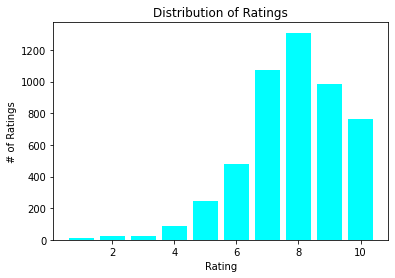

In [63]:
# plot distribution in matplotlib
ratings_sorted = sorted(list(zip(ratings_y.index, ratings_y)))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='cyan')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

In [64]:
#number of users
print("Number of Users:", df_merge.user_id.nunique())
# print("Average Number of Reviews per User:", df_merge.shape[0])/df_merge.user_id.nunique()
avg_rate_peruser = df_merge.shape[0]
user = df_merge.user_id.nunique()
avg_num_review_per_user = avg_rate_peruser/user
print("Average Number of Reveiws per User:", avg_num_review_per_user)

Number of Users: 19981
Average Number of Reveiws per User: 88.57554676943096


In [65]:
sample['user_id'].value_counts()

7345     7
7247     6
4690     6
6265     6
6569     6
        ..
15301    1
3011     1
17586    1
17330    1
16384    1
Name: user_id, Length: 3679, dtype: int64

## Number of Reviews per User

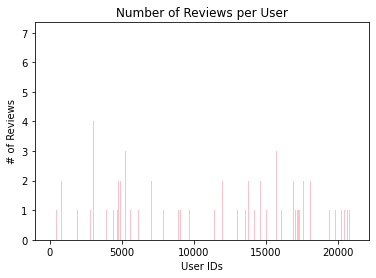

In [66]:
ratings_per_user = sample['user_id'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user], color='pink')
plt.xlabel('User IDs')
plt.ylabel('# of Reviews')
plt.title('Number of Reviews per User')
plt.show()

In [0]:
#graph on user ratings, what are the most common scores given 

## Different types of anime videos

In [68]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())
print("Types of type:", sample.type.value_counts())

Number of users: 3679
Number of types of different anime: 6
Types of type: TV         3522
Movie       653
OVA         461
Special     307
ONA          43
Music        14
Name: type, dtype: int64


This means that there are six different categories for anime: <br>
Movies, TV, OVA, Special, ONA and Music. <br>
***OVA stands for orginal animation video, this has been released directly to the video market <br>
Special is not a common occuring video, it is usually shot yearly or on a one off <br>
Music is not just audio here, but a lively animated motion picture to go with the composed music piece ***

In [69]:
sample_of_sample = sample[:100] #taking a sample to see if its the amount of data or its the command given
sample_of_sample

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
811431,11111,Another,"Horror, Mystery, School, Supernatural, Thriller",TV,12,8,534657,3362,8.0
1158738,270,Hellsing,"Action, Horror, Seinen, Supernatural, Vampire",TV,13,8,308995,14160,6.0
1487262,326,Petshop of Horrors,"Horror, Josei, Mystery, Supernatural",TV,4,7,32696,5818,6.0
1493092,940,Inukami!,"Comedy, Ecchi, Romance, Shounen, Supernatural",TV,26,7,47882,21072,9.0
421673,2025,Darker than Black: Kuro no Keiyakusha,"Action, Mystery, Sci-Fi, Super Power",TV,25,8,440334,4973,10.0
...,...,...,...,...,...,...,...,...,...
726825,14741,Chuunibyou demo Koi ga Shitai!,"Comedy, Drama, Romance, School, Slice of Life",TV,12,8,394399,14168,7.0
561680,27831,Durarara!!x2 Ten,"Action, Mystery, Supernatural",TV,12,8,132506,15042,7.0
1018467,740,Bishoujo Senshi Sailor Moon R,"Demons, Magic, Romance, Shoujo",TV,43,8,73305,7135,9.0
1256817,5355,Sengoku Basara,"Action, Historical, Martial Arts, Samurai, Sup...",TV,12,8,93940,2641,7.0


In [70]:
sample.loc[sample['type'] == 'Movie']

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
147647,578,Hotaru no Haka,"Drama, Historical",Movie,1,9,174878,10168,8.0
1231308,1686,Bleach Movie 1: Memories of Nobody,"Action, Adventure, Super Power",Movie,1,8,151598,12702,5.0
1850710,1192,Kakurenbo,"Horror, Psychological, Supernatural",Movie,1,7,22853,5261,9.0
581154,1689,Byousoku 5 Centimeter,"Drama, Romance, Slice of Life",Movie,3,8,324035,13494,10.0
466166,1506,Detective Conan Movie 10: Requiem of the Detec...,"Adventure, Comedy, Mystery, Police, Shounen",Movie,1,8,21789,20955,9.0
...,...,...,...,...,...,...,...,...,...
1119616,27411,Ghost in the Shell (2015),"Action, Mecha, Police, Psychological, Sci-Fi",Movie,1,8,19872,4274,8.0
691941,14349,Little Witch Academia,"Adventure, Comedy, Fantasy, Magic, School",Movie,1,8,111703,4370,9.0
1273189,25389,Dragon Ball Z Movie 15: Fukkatsu no F,"Action, Adventure, Comedy, Fantasy, Martial Ar...",Movie,1,8,41051,18349,7.0
1229410,24919,Aoki Hagane no Arpeggio: Ars Nova DC,"Action, Sci-Fi, Seinen",Movie,1,8,11943,9461,9.0


In [71]:
len(sample.loc[sample['type'] == 'TV']) #How many tv shows there are in the dataframe

3522

In [72]:
len(sample.loc[sample['type'] == 'Movie'])

653

In [73]:
sample.loc[sample['type'] == 'Movie'].rating_x.value_counts() #Viewer ratings for films 

8    396
7    151
9     98
6      6
5      1
4      1
Name: rating_x, dtype: int64

In [74]:
sample.loc[sample['type'] == 'Movie'].rating_y.value_counts() #Viewer ratings for films 

8.0     169
9.0     154
7.0     122
10.0    109
6.0      61
5.0      25
4.0       6
2.0       3
3.0       2
1.0       2
Name: rating_y, dtype: int64

***drop rows containing -1 as rating in df_merge ***
could be that I have an approximation error 

*** Look at min ratings in rating_x *** if its a rating error, we would recreate y based off of x. (round to a whole number) *** 0 decimal places

## Most Reviewed Videos

In [75]:
movies_review = len(sample.loc[sample['type'] == 'Movie'])
movies_review

653

In [76]:
tv_reviews = len(sample.loc[sample['type'] == 'TV'])
tv_reviews

3522

In [77]:
ova_reviews = len(sample.loc[sample['type'] =='OVA'])
ova_reviews

461

In [78]:
music_reviews = len(sample.loc[sample['type'] =='Music'])
music_reviews

14

In [79]:
ona_reviews = len(sample.loc[sample['type'] =='ONA'])
ona_reviews

43

In [80]:
special_reviews = len(sample.loc[sample['type'] =='Special'])
special_reviews

307

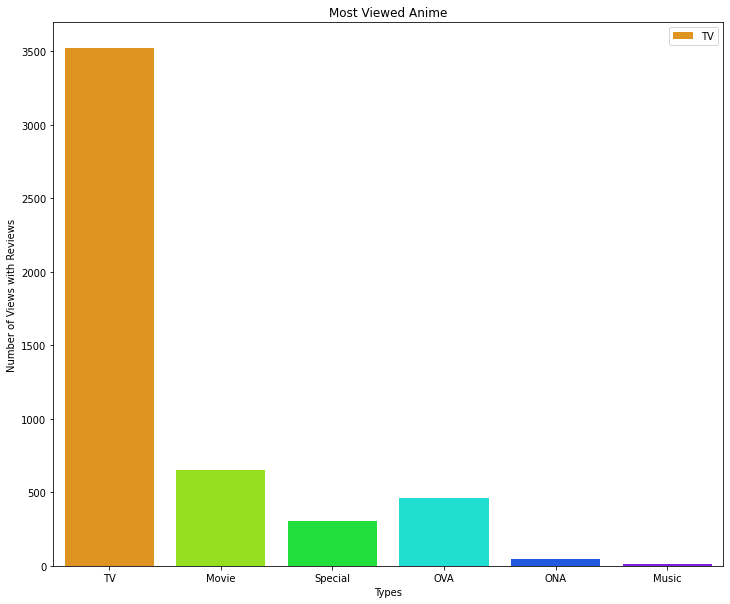

In [81]:
# PLOT them 
fig = plt.figure(figsize=(12,10))
sns.countplot(sample['type'], palette='gist_rainbow')
plt.title("Most Viewed Anime")
plt.xlabel("Types")
plt.ylabel("Number of Views with Reviews")
plt.legend(sample['type'])
plt.show()

In [82]:
len(sample)

5000

# Collaborative Models

In [0]:
class MyDataset(dataset.DatasetAutoFolds):
  #surprise.dataset.DatasetAutoFolds creates a surprise friendly dataset
  #this will give it folds so that cross validation can be performed efficiently
  def __init__(self, sample, reader):
    self.sample = [(uid, iid, r, None) for (uid, iid, r) in 
                   zip (sample['user_id'], sample['anime_id'], sample['rating_x'])]
    self.reader = reader

In [0]:
# #instantiate the reader parser object
#reader = Reader(line_format = 'user item rating', rating_scale = (0.0, 10.0))

In [0]:
# #parse sample set into a surprise friendly dataset
#data = MyDataset(sample, reader)

In [0]:
reader = Reader(line_format = 'user item rating', rating_scale = (0.0, 10.0))
data = sample[['user_id', 'anime_id', 'rating_x']]
anime_data = Dataset.load_from_df(data, reader)

In [87]:
type(data)

pandas.core.frame.DataFrame

# Train Validation Split

In [0]:
trainset, testset = train_test_split(anime_data, test_size=.2)

# Memory Based Knn Method

## KNN Basic with cosine similarity

In [0]:
#cosine similarity 
sim_cos = {'name': 'cosine', 'user_based':True}

#instantiate the model with the similarity setting
knn_sim_cos = knns.KNNBasic(sim_options=sim_cos)

In [90]:
# fit the model
sim_cos_cv = cross_validate(knn_sim_cos, anime_data, measures=['rmse', 'mae'], cv=3,
                            return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7295  0.7280  0.7400  0.7325  0.0053  
MAE (testset)     0.6055  0.5972  0.6002  0.6009  0.0034  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.91    0.98    0.74    0.88    0.10    
Test time         0.04    0.02    0.02    0.03    0.01    


*** 

### The test set is not great but not terribly bad. I am not sure why the train set is not showing up. 

## 2nd Model: KNN Basic (item based)

In [0]:
#cosine similarity 
sim_cos = {'name': 'cosine', 'user_based': False}

#instantiate the knnBasic with sim_cos settings
knn_basic_simcos = knns.KNNBasic(sim_options=sim_cos)


In [92]:
#fit the model 
cv_knn_basic_simcos = cross_validate(knn_basic_simcos, anime_data, measures=['rmse', 'mae'], cv =3, return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7430  0.7430  0.7126  0.7329  0.0143  
MAE (testset)     0.6105  0.6022  0.5912  0.6013  0.0079  
RMSE (trainset)   0.3171  0.3202  0.3127  0.3167  0.0031  
MAE (trainset)    0.1369  0.1375  0.1344  0.1363  0.0014  
Fit time          0.11    0.13    0.08    0.11    0.02    
Test time         0.02    0.02    0.01    0.02    0.00    


In [0]:
#This one performed better than the last and the trainset is showing up. WOOH!

##3rd Baseline Model: A user based pearson similarity using KNNBasline

In [0]:
sim_pearson = {'name': 'pearson', 'user_based': True}

#instantiate KNNBasline with pearson 
knn_baseline_pearson = knns.KNNBaseline(sim_options=sim_pearson)

In [95]:
#fit and cross validate model 
cv_knnbaseline_simpearson = cross_validate(knn_baseline_pearson, anime_data, measures=['rmse', 'mae'], cv=3,
                                           return_train_measures=True, n_jobs=2, verbose=True)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6401  0.5891  0.6014  0.6102  0.0217  
MAE (testset)     0.4995  0.4782  0.4822  0.4866  0.0092  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.57    0.54    0.37    0.49    0.09    
Test time         0.02    0.02    0.01    0.02    0.00    


### This user based model with sim pearson did not do as well. Again, user based does not produce trainset results

## 4th Model: Item based pearson similarity using KNNBaseline

In [0]:
sim_pearson = {'name':'pearson', 'user_based': False}

#instantiate KNNBasline 
knn_baseline_item = knns.KNNBaseline(sim_options=sim_pearson)

In [99]:
#fit and cross validate
cv_knnbaseline_item = cross_validate(knn_baseline_item, anime_data, measures=['rmse', 'mae'], cv=3, 
                                     return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6439  0.5942  0.5969  0.6117  0.0228  
MAE (testset)     0.5067  0.4735  0.4819  0.4873  0.0141  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.14    0.20    0.17    0.17    0.02    
Test time         0.02    0.02    0.01    0.02    0.00    


### This model hasn't performed well and also for some reason has not given trainset RMSE and MAE

## 5th Model: User based using KNNWithMeans with pearson 

In [0]:
sim_pearson = {'name': 'pearson', 'user_based': True}

#instantiating KNNWithMeans
knn_withmeans_user = knns.KNNWithMeans(sim_options=sim_pearson)

In [101]:
#fit and cross validate 
cv_knnwithmeans_user = cross_validate(knn_withmeans_user, anime_data, measures=['rmse','mae'], cv=3, return_train_measures=True, 
                                      n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7852  0.7735  0.8029  0.7872  0.0121  
MAE (testset)     0.6284  0.6046  0.6311  0.6214  0.0119  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.50    0.78    0.72    0.67    0.12    
Test time         0.02    0.02    0.01    0.02    0.00    


#### This test set has the best performance yet, but no idea why the trainset is not showing up. 

## 6th Model: KNNWithMeans but item based

In [0]:
sim_pearson = {'name': 'pearson', 'user_based':False}

#instantiate 
knn_withmeans_item = knns.KNNWithMeans(sim_options=sim_pearson)


In [104]:
#fit and cross validate
cv_knnwithmeans_item = cross_validate(knn_withmeans_item, anime_data, measures=['rmse', 'mae'], cv=3,
                                      return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6368  0.6682  0.6560  0.6536  0.0129  
MAE (testset)     0.4592  0.4744  0.4687  0.4674  0.0063  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.32    0.19    0.14    0.22    0.07    
Test time         0.04    0.02    0.01    0.02    0.01    


#### The item based for pearson on the KNNWithMeans does not perform as well

# Model Based Methods

## Alternating Least Squares

### 7th Model with hyperparameter tuning

In [105]:
# create parameter permutations
epochs = [3, 5, 10, 20]
reg_u = [5, 10, 12, 15, 20]
reg_i = [3, 5, 10, 15]

params = [[i, j, k] for i in epochs
          for j in reg_u
          for k in reg_i]
print('Number of grid search permutation:', len(params))


Number of grid search permutation: 80


In [106]:
baseline_option_score = {}

for basline_perm in params: 
  basline_options = {'method': 'als',
                     'n_epochs': bsl_perm[0],
                     'reg_u': bsl_perm[1],
                     'reg_i': bsl_perm[2]}
  #instantiate
  algo = baseline_only.BaselineOnly(bsl_options=baseline_options)
  #fit and cross validate
  cv_algo = cross_validate(algo, anime_data, measures=['rmse', 'mae'], cv =3, 
                           verbose = False, return_train_measures=True);
  bsl_perm2 = (str(bsl_perm[0]) + ' ' + str(bsl_perm[1]) + ' ' + str(bsl_perm[2]))
  baseline_option_score[bsl_perm2] = {'mean_train_rmse': cv_algo['train_rmse'].mean(), 'mean_test_rmse': a['test_rmse'].mean()}

  #print('\n', baseline_options, '\n', '\n\')

NameError: ignored

# Implementing a Surprise's Singular Value Decomposition (SVD) as a Baseline

In [0]:
sample.rating_x = sample.rating_x.apply(round)
sample.head()

In [0]:
#for surprise, it likes its data in a certain way and only that specific data
data = sample[['user_id', 'anime_id', 'rating_x']] #may need to do rating_x rounded and then use rating_y
reader = Reader(line_format='user item rating', sep='')
anime_loaded_data = Dataset.load_from_df(data, reader)
# anime_split = anime_loaded_data.split(n_folds=5) 

#train_test_split
trainset, testset = train_test_split(anime_loaded_data, test_size=.2)

In [0]:
anime_loaded_data

In [0]:
#INSTANTIATE the SVD and fit only the train set
svd = SVD()
svd.fit(trainset)

In [0]:
predictions = svd.test(testset) #
accuracy.rmse(predictions)

In [0]:
predictions[:10]

In [0]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())


In [0]:
user = 5
item = 100
svd.predict(user, item)

Now I need to compare the different models and see which ones perform best. I will stick to using RMSE to evaluate the models. I will also cross validate. 

In [0]:
#perform a gridsearch CV
params = {'n_factors': [20,50,100],
         'reg_all': [.02,.05, .10]}
gridsearch_svd1 = GridSearchCV(SVD, param_grid=params, n_jobs=-1, joblib_verbose=3)
gridsearch_svd1.fit(anime_loaded_data)

In [0]:
print(gridsearch_svd1.best_score)
print(gridsearch_svd1.best_params)

In [0]:
anime_loaded_data

## Cross Validation with K-Nearest Neighbors (KNN) Basic Algorithm

In [0]:
#cross validate with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=True)
cv_knn_basic = cross_validate(knn_basic, anime_loaded_data, n_jobs=2)

In [0]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic['test_rmse']))

In [0]:
knn_basic_msd = KNNBasic(sim_options = {'name': 'msd', 'user-based':True})
cv_knn_basic_msd = cross_validate(knn_basic_msd, anime_loaded_data, n_jobs=2)

In [0]:
for i in cv_knn_basic_msd.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic_msd['test_rmse']))

## Cross Validation with KNN Baseline

In [0]:
#cross validate with KNN Baseline (pearson)
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, anime_loaded_data, n_jobs=3)

In [0]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_baseline['test_rmse']))

In [0]:
knn_baseline_msd = KNNBaseline(sim_options = {'name': 'msd', 'user_based': True})
cv_knn_baseline_msd = cross_validate(knn_baseline_msd, anime_loaded_data, n_jobs =2)

In [0]:
for i in cv_knn_baseline_msd.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_baseline_msd['test_rmse']))

## Cross Validate with KNNBaseline using pearson baseline

In [0]:
knn_pearson_baseline = KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based':True})
cv_knn_pearson_baseline = cross_validate(knn_pearson_baseline, anime_data, n_jobs=3)

In [0]:
for i in cv_knn_pearson_baseline.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_pearson_baseline['test_rmse']))

## KNN with Means 

In [0]:
knn_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
cv_knn_means = cross_validate(knn_means, anime_data, n_jobs=3)

In [0]:
for i in cv_knn_means.items():
  print(i)
print('------------')
print(np.mean(cv_knn_means['test_rmse']))

In [0]:
knn_means_msd = KNNWithMeans(sim_options={'name': 'msd', 'user_based':True})
cv_knn_means_msd = cross_validate(knn_means_msd, anime_data, n_jobs = 2)

In [0]:
for i in cv_knn_means_msd.items():
  print(i)
print('-------------')
print(np.mean(cv_knn_means_msd['test_rmse']))

## Tuning the Best Algorithm with GridSearchCV
Best model so far is KNN Baseline with Mean Squared Distance

In [0]:
param_grid = {'n_factors': [5, 20, 100], 
              'n_epochs': [5,10], 
              'lr_all': [.002, .005], 
              'reg_all': [.02, .05, .5]}
knn_baseline_gs = GridSearchCV(KNNBaseline, param_grid=param_grid, n_jobs=3, joblib_verbose=3)
knn_baseline_gs.fit(anime_data)

In [0]:
print(knn_baseline_gs.best_score)
print(knn_baseline_gs.best_params)

In [0]:
#Now use this to fit test set, initial gridsearch was 2.77096, so will use that gs here
highest_perf_algo = gridsearch_svd1.best_estimator['rmse']

In [0]:
#retrain the whole set
trainset = anime_data.build_full_trainset()
highest_perf_algo.fit(trainset)

In [0]:
#Biased Accuracy on trainset
predictions = highest_perf_algo.test(trainset.build_testset())
print('Biased accuracy on Trainset', end='')
accuracy.rmse(predictions)

In [0]:
#UnBiased Accuracy on testset
predictions = highest_perf_algo.test(testset)
print('Unbiased Accuracy on test', end='')
accuracy.rmse(predictions)

# WILL NOT CONTINUE USING PYSPARK! JUST REMEMBERED THAT THE LEARNCO IS OUTDATED

# Pyspark 

In [0]:
!pip install pyspark

In [0]:
from pyspark.sql import SparkSession 

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [0]:
#instantiate SparkSession object 
spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [0]:
sample.to_csv('sample.csv', index='False')

In [0]:
#read in data into pyspark dataframe
sample = spark.read.csv('./sample.csv', header='true', inferSchema='true')

## Fitting the Alternating Least Squares Model

In [0]:
from pyspark.ml.tuning.TrainValidationSplit


In [0]:
#TRAIN TEST SPLIT
trainset, testset = anime_loaded_data.randomSplit([.8, .2])

In [0]:
#Build a recommendation model using ALS on the training data
als = ALS(maxIter=5,
         rank=4, 
         regParam=.01, 
         userCol='user_id',
         itemCol='anime_id',
         ratingCol='rating',
         coldStartStrategy='drop')
#fit the ALS to training set
als_model = als.fit(trainset)

In [0]:
#Let's evaluate its performance, above with surprise we got an unrealistic RMSE of 2.75
#start wtih a regression evaluator
from pyspark.ml.evaluation import RegressionEvaluator 
#let's compute the ALS RMSE on the testset
predictions = als_model.transform(testset)
evaluator = RegressionEvaluator(metricName='rmse',
                               labelCol='rating',
                               predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print("Root Mean Square Error:", str(rmse))


## Cross Validation to find the optimal model 